In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, confusion_matrix

import joblib  # lightweight pipelining in Python
import json
import os

import matplotlib
import matplotlib.pyplot as plt

In [2]:
! jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [3]:
! jt -t grade3 # select a theme

In [ ]:
! jt -t gruvboxd -cellw 90% -lineh 100 # select a theme with cell width and line spacing

In [1]:
# ! jt -r # return to default

Reset css and font defaults in:
/Users/antongusarov/.jupyter/custom &
/Users/antongusarov/Library/Jupyter/nbextensions


# Config

In [3]:
# Base
random_state = 42

# Raw data
target_raw = '../data/raw/target.feather'
user_features_raw = '../data/raw/user_features.feather'

# Features
categories = ['feature_17', 'feature_21', 'feature_11', 'feature_16', 'feature_22']  
features_path = '../data/processed/features.feather'

# Train
top_K_coef = 0.05  # calculate metrics for top 5%
model_path = '../models/model.joblib'
train_metrics = '../reports/train_metrics.json'

# Create features

## Load data

In [4]:
target_df = pd.read_feather(target_raw)
target_df.head()

,user_id,month,target
0,0,2020-04-30,1.0
1,0,2020-05-31,0.0
2,0,2020-06-30,1.0
3,0,2020-07-31,0.0
4,0,2020-08-31,1.0


In [5]:
target_df.shape

(752128, 3)

In [6]:
target_df.month.astype(str).unique()

array(['2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
       '2020-08-31'], dtype=object)

In [7]:
# imbalanced
target_df.target.value_counts()

0.0    458874
1.0    293254
Name: target, dtype: int64

In [8]:
target_df.month.value_counts()

2020-08-31    150554
2020-07-31    150492
2020-04-30    150484
2020-05-31    150411
2020-06-30    150187
Name: month, dtype: int64

In [9]:
user_features_df = pd.read_feather(user_features_raw)
user_features_df = user_features_df.loc[user_features_df.user_id.isin(target_df.user_id)]
user_features_df.head()

,user_id,month,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,0,2020-04-30,0.993121,-15,2.274309,18,2868,-1.305588,-0.097643,0.617778,...,H4V75OQHSRBLA,AOKOISPPQLWGKK,-3.146305,-1.655508,25,3.032537,-29960,-1.864660,-0.212668,-3.245333
1,0,2020-05-31,-1.416912,-145,-1.087891,-8,-1763,-1.322007,3.143865,-0.272231,...,AUEOMIKY5CRWBNWO7S,OORLO7PMHCZFEMSR,2.365636,-2.632201,-11,-2.373654,-173398,0.458990,1.376687,-0.460150
2,0,2020-06-30,0.673564,23,0.016666,-7,-4092,-0.936663,-1.909813,0.715618,...,4VPOKVAQSMMTDZQ,NZFU27MWLPZRTX4G5D,-2.220931,1.930994,-10,3.301401,-46619,0.269820,0.900846,0.315063
3,0,2020-07-31,-2.124908,-15,1.234815,18,9348,0.233297,-0.108647,-1.831460,...,RAGXKIMJHFFGKA,KQBIGTVRDJZJLQRRPPY,1.641780,-5.166544,-23,0.531913,-131224,-0.341103,0.208832,1.869453
4,0,2020-08-31,-2.122264,-50,-0.584464,-8,1894,-0.092315,-0.547480,-0.065323,...,RAGXKIMJHFFGKA,KQBIGTVRDJZJLQRRPPY,1.852084,-0.761511,-24,-1.080867,68577,-1.328331,-0.681723,0.431699


In [10]:
user_features_df.user_id.isin(target_df.user_id)

0         True
1         True
2         True
3         True
4         True
          ... 
752123    True
752124    True
752125    True
752126    True
752127    True
Name: user_id, Length: 752128, dtype: bool

In [11]:
user_features_df.user_id.isin(target_df.user_id).value_counts()

True    752128
Name: user_id, dtype: int64

In [8]:
user_features_df.month.value_counts()

2020-08-31    150554
2020-07-31    150492
2020-04-30    150484
2020-05-31    150411
2020-06-30    150187
Name: month, dtype: int64

## Process 'month' column

In [11]:
# Convert 'month' to datetime
target_df['month'] = pd.to_datetime(target_df['month'])
user_features_df['month'] = pd.to_datetime(user_features_df['month'])

In [19]:
target_df.head()

,user_id,month,target
0,0,2020-04-30,1.0
1,0,2020-05-31,0.0
2,0,2020-06-30,1.0
3,0,2020-07-31,0.0
4,0,2020-08-31,1.0


In [12]:
features = user_features_df.copy()
features.head()

,user_id,month,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,0,2020-04-30,0.993121,-15,2.274309,18,2868,-1.305588,-0.097643,0.617778,...,H4V75OQHSRBLA,AOKOISPPQLWGKK,-3.146305,-1.655508,25,3.032537,-29960,-1.864660,-0.212668,-3.245333
1,0,2020-05-31,-1.416912,-145,-1.087891,-8,-1763,-1.322007,3.143865,-0.272231,...,AUEOMIKY5CRWBNWO7S,OORLO7PMHCZFEMSR,2.365636,-2.632201,-11,-2.373654,-173398,0.458990,1.376687,-0.460150
2,0,2020-06-30,0.673564,23,0.016666,-7,-4092,-0.936663,-1.909813,0.715618,...,4VPOKVAQSMMTDZQ,NZFU27MWLPZRTX4G5D,-2.220931,1.930994,-10,3.301401,-46619,0.269820,0.900846,0.315063
3,0,2020-07-31,-2.124908,-15,1.234815,18,9348,0.233297,-0.108647,-1.831460,...,RAGXKIMJHFFGKA,KQBIGTVRDJZJLQRRPPY,1.641780,-5.166544,-23,0.531913,-131224,-0.341103,0.208832,1.869453
4,0,2020-08-31,-2.122264,-50,-0.584464,-8,1894,-0.092315,-0.547480,-0.065323,...,RAGXKIMJHFFGKA,KQBIGTVRDJZJLQRRPPY,1.852084,-0.761511,-24,-1.080867,68577,-1.328331,-0.681723,0.431699


In [12]:
# features.sort_values(by=['month']).tail()

## Add target column

In [13]:
%%time

features = pd.merge(
        left=features,
        right=target_df,
        how='left',
        on=['user_id', 'month']
)


features.head()

CPU times: user 502 ms, sys: 191 ms, total: 693 ms
Wall time: 699 ms


,user_id,month,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,target
0,0,2020-04-30,0.993121,-15,2.274309,18,2868,-1.305588,-0.097643,0.617778,...,AOKOISPPQLWGKK,-3.146305,-1.655508,25,3.032537,-29960,-1.864660,-0.212668,-3.245333,1.0
1,0,2020-05-31,-1.416912,-145,-1.087891,-8,-1763,-1.322007,3.143865,-0.272231,...,OORLO7PMHCZFEMSR,2.365636,-2.632201,-11,-2.373654,-173398,0.458990,1.376687,-0.460150,0.0
2,0,2020-06-30,0.673564,23,0.016666,-7,-4092,-0.936663,-1.909813,0.715618,...,NZFU27MWLPZRTX4G5D,-2.220931,1.930994,-10,3.301401,-46619,0.269820,0.900846,0.315063,1.0
3,0,2020-07-31,-2.124908,-15,1.234815,18,9348,0.233297,-0.108647,-1.831460,...,KQBIGTVRDJZJLQRRPPY,1.641780,-5.166544,-23,0.531913,-131224,-0.341103,0.208832,1.869453,0.0
4,0,2020-08-31,-2.122264,-50,-0.584464,-8,1894,-0.092315,-0.547480,-0.065323,...,KQBIGTVRDJZJLQRRPPY,1.852084,-0.761511,-24,-1.080867,68577,-1.328331,-0.681723,0.431699,1.0


In [14]:
features['target'].value_counts(dropna=False)

0.0    458874
1.0    293254
Name: target, dtype: int64

In [23]:
features.shape

(752128, 33)

In [15]:
(
    user_features_df
    .merge(target_df[target_df.target == 1], 
           how="left", 
           on=["user_id", "month"])
    .fillna({"target": 0})
    .groupby("user_id")
    .agg({"target": "sum"})
    .value_counts()
    .sort_index()
)

target
0.0       49354
1.0       86519
2.0       61592
3.0       22215
4.0        3924
5.0         242
dtype: int64

## Process nulls 

In [17]:
# Fill NaN target 0 
features.dropna(inplace=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752128 entries, 0 to 752127
Data columns (total 33 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     752128 non-null  int64         
 1   month       752128 non-null  datetime64[ns]
 2   feature_1   752128 non-null  float64       
 3   feature_2   752128 non-null  int32         
 4   feature_3   752128 non-null  float64       
 5   feature_4   752128 non-null  int32         
 6   feature_5   752128 non-null  int32         
 7   feature_6   752128 non-null  float64       
 8   feature_7   752128 non-null  float64       
 9   feature_8   752128 non-null  float64       
 10  feature_9   752128 non-null  float64       
 11  feature_10  752128 non-null  float64       
 12  feature_11  752128 non-null  category      
 13  feature_12  752128 non-null  float64       
 14  feature_13  752128 non-null  float64       
 15  feature_14  752128 non-null  float64       
 16  fe

## Save features

In [18]:
features.to_feather(features_path)  # binary Feather format

In [19]:
! tree ../data  # features is in processed dir

../data
├── processed
│   └── features.feather
└── raw
    ├── scoring_target.feather
    ├── scoring_user_features.feather
    ├── target.feather
    └── user_features.feather

2 directories, 5 files


# Split data

Time-based cross validation: forms a type of “sliding window” training approach to create a general and robust model.

Example for reference: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8 

In [20]:
from pandas.tseries.offsets import MonthEnd

def custom_ts_split(months, train_period = 0):
    for k, month in enumerate(months):   
        start_train = pd.to_datetime(months.min())
        end_train = start_train + MonthEnd(train_period + k-1)
        test_period = pd.to_datetime(end_train + MonthEnd(1))
        
        if test_period <= pd.to_datetime(months.max()):
            yield start_train, end_train, test_period
        else: 
            print(test_period)
            print(months.max())

In [21]:
# months
months = features.month.sort_values().unique()
months

array(['2020-04-30T00:00:00.000000000', '2020-05-31T00:00:00.000000000',
       '2020-06-30T00:00:00.000000000', '2020-07-31T00:00:00.000000000',
       '2020-08-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [22]:
# test custom_ts_split function - iterate over splits 
k = 1
for start_train, end_train, test_period in custom_ts_split(months, train_period=1):
        print(f'Fold {k}:')    
        print(f'Train: {start_train} - {end_train}')
        print(f'Test: {test_period} \n')
        k+=1

Fold 1:
Train: 2020-04-30 00:00:00 - 2020-04-30 00:00:00
Test: 2020-05-31 00:00:00 

Fold 2:
Train: 2020-04-30 00:00:00 - 2020-05-31 00:00:00
Test: 2020-06-30 00:00:00 

Fold 3:
Train: 2020-04-30 00:00:00 - 2020-06-30 00:00:00
Test: 2020-07-31 00:00:00 

Fold 4:
Train: 2020-04-30 00:00:00 - 2020-07-31 00:00:00
Test: 2020-08-31 00:00:00 

2020-09-30 00:00:00
2020-08-31T00:00:00.000000000


# Train

## Metrics

Reference: https://towardsdatascience.com/the-lift-curve-unveiled-998851147871

### Lift Curve

In [1]:
def plot_Lift_curve(y_true, y_pred, step=0.01):
    """
    Plots a Lift curve using the real label values of a dataset 
    and the probability predictions of a Machine Learning Algorithm/model
    
    Params:
    y_val: true labels
    y_pred: probability predictions
    step: steps in the percentiles
    
    Reference: https://towardsdatascience.com/the-lift-curve-unveiled-998851147871
    """
    
    # Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    aux_lift['real'] = y_true
    aux_lift['predicted'] = y_pred
    aux_lift.sort_values('predicted', ascending=False, inplace=True)
   
    x_val = np.arange(step, 1+step, step)  # values on the X axis of our plot
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)  # ratio of ones in our data
    y_v = []  # empty vector with the values that will go on the Y axis our our plot
    
    # for each x value calculate its corresponding y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift)))
        data_here = aux_lift.iloc[:num_data,:]
        ratio_ones_here = data_here['real'].sum() / len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   # plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth= 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()
    

### Precision @k

In [23]:
def precision_at_k_score(actual, predicted, predicted_probas, k) -> float:
    
    df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'probas': predicted_probas})
    df = df.sort_values(by=['probas'], ascending=False).reset_index(drop=True)
    df = df[:k]

    return precision_score(df['actual'], df['predicted'])

### Recall @k

In [24]:
def recall_at_k_score(actual, predicted, predicted_probas, k) -> float:

    df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'probas': predicted_probas})
    df = df.sort_values(by=['probas'], ascending=False).reset_index(drop=True)
    df = df[:k]

    return recall_score(df['actual'], df['predicted'])


### Lift @k

In [25]:
def lift_score(actual, predicted, predicted_probas, k) -> float:
 
    numerator = precision_at_k_score(actual, predicted, predicted_probas, k)
    denominator = np.mean(actual)

    lift = numerator / denominator

    print(f'Lift: {numerator} / {denominator} = {lift}')

    return lift

## Load data 

In [27]:
features = pd.read_feather(features_path)

# format data
features['month'] = pd.to_datetime(features['month'])
features.head()

,user_id,month,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,target
0,0,2020-04-30,0.993121,-15,2.274309,18,2868,-1.305588,-0.097643,0.617778,...,AOKOISPPQLWGKK,-3.146305,-1.655508,25,3.032537,-29960,-1.864660,-0.212668,-3.245333,1.0
1,0,2020-05-31,-1.416912,-145,-1.087891,-8,-1763,-1.322007,3.143865,-0.272231,...,OORLO7PMHCZFEMSR,2.365636,-2.632201,-11,-2.373654,-173398,0.458990,1.376687,-0.460150,0.0
2,0,2020-06-30,0.673564,23,0.016666,-7,-4092,-0.936663,-1.909813,0.715618,...,NZFU27MWLPZRTX4G5D,-2.220931,1.930994,-10,3.301401,-46619,0.269820,0.900846,0.315063,1.0
3,0,2020-07-31,-2.124908,-15,1.234815,18,9348,0.233297,-0.108647,-1.831460,...,KQBIGTVRDJZJLQRRPPY,1.641780,-5.166544,-23,0.531913,-131224,-0.341103,0.208832,1.869453,0.0
4,0,2020-08-31,-2.122264,-50,-0.584464,-8,1894,-0.092315,-0.547480,-0.065323,...,KQBIGTVRDJZJLQRRPPY,1.852084,-0.761511,-24,-1.080867,68577,-1.328331,-0.681723,0.431699,1.0


In [28]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752128 entries, 0 to 752127
Data columns (total 33 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     752128 non-null  int64         
 1   month       752128 non-null  datetime64[ns]
 2   feature_1   752128 non-null  float64       
 3   feature_2   752128 non-null  int32         
 4   feature_3   752128 non-null  float64       
 5   feature_4   752128 non-null  int32         
 6   feature_5   752128 non-null  int32         
 7   feature_6   752128 non-null  float64       
 8   feature_7   752128 non-null  float64       
 9   feature_8   752128 non-null  float64       
 10  feature_9   752128 non-null  float64       
 11  feature_10  752128 non-null  float64       
 12  feature_11  752128 non-null  category      
 13  feature_12  752128 non-null  float64       
 14  feature_13  752128 non-null  float64       
 15  feature_14  752128 non-null  float64       
 16  fe

## Fit

In [26]:
import catboost as ctb

clf = ctb.CatBoostClassifier(
    iterations = 10, 
    thread_count = 50, 
    has_time = True, 
    allow_writing_files = False,
    cat_features = categories,
    loss_function = "Logloss",
#     eval_metric='AUC',
)

In [29]:
top_K_coef # defined above in Config section 

0.05

top_K is 5.0 % of dataset_size: 37606
Fold 1:
Train: 2020-04-30 00:00:00 - 2020-04-30 00:00:00
Test: 2020-05-31 00:00:00 

Train shapes: X - (150484, 30), y - (150484,)
Test shapes: X - (150411, 30), y - (150411,)
Learning rate set to 0.5
0:	learn: 0.5949235	total: 179ms	remaining: 1.61s
1:	learn: 0.5593754	total: 303ms	remaining: 1.21s
2:	learn: 0.5432368	total: 411ms	remaining: 959ms
3:	learn: 0.5085961	total: 517ms	remaining: 775ms
4:	learn: 0.4996222	total: 617ms	remaining: 617ms
5:	learn: 0.4875087	total: 733ms	remaining: 489ms
6:	learn: 0.4764198	total: 848ms	remaining: 363ms
7:	learn: 0.4701489	total: 942ms	remaining: 236ms
8:	learn: 0.4664546	total: 1.05s	remaining: 117ms
9:	learn: 0.4629525	total: 1.17s	remaining: 0us
Max probas: 0.9748887441234043
Lift: 0.8227676434611498 / 0.39038368204453133 = 2.1075871797512686
Precision at 37606: 0.8227676434611498
Recall at 37606: 1.0


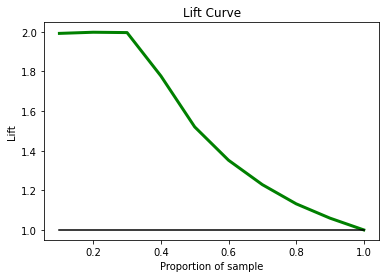



Fold 2:
Train: 2020-04-30 00:00:00 - 2020-05-31 00:00:00
Test: 2020-06-30 00:00:00 

Train shapes: X - (300895, 30), y - (300895,)
Test shapes: X - (150187, 30), y - (150187,)
Learning rate set to 0.5
0:	learn: 0.6046554	total: 136ms	remaining: 1.23s
1:	learn: 0.5515906	total: 246ms	remaining: 986ms
2:	learn: 0.5238548	total: 354ms	remaining: 826ms
3:	learn: 0.5104332	total: 471ms	remaining: 706ms
4:	learn: 0.4905131	total: 583ms	remaining: 583ms
5:	learn: 0.4825724	total: 693ms	remaining: 462ms
6:	learn: 0.4747321	total: 812ms	remaining: 348ms
7:	learn: 0.4669002	total: 937ms	remaining: 234ms
8:	learn: 0.4620151	total: 1.06s	remaining: 118ms
9:	learn: 0.4551009	total: 1.19s	remaining: 0us
Max probas: 0.9728085269755247
Lift: 0.8294155188001915 / 0.38953438047234445 = 2.129248560279718
Precision at 37606: 0.8294155188001915
Recall at 37606: 1.0


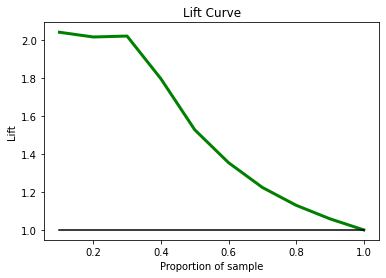



Fold 3:
Train: 2020-04-30 00:00:00 - 2020-06-30 00:00:00
Test: 2020-07-31 00:00:00 

Train shapes: X - (451082, 30), y - (451082,)
Test shapes: X - (150492, 30), y - (150492,)
Learning rate set to 0.5
0:	learn: 0.6046007	total: 184ms	remaining: 1.65s
1:	learn: 0.5514077	total: 359ms	remaining: 1.44s
2:	learn: 0.5219602	total: 528ms	remaining: 1.23s
3:	learn: 0.5061158	total: 668ms	remaining: 1s
4:	learn: 0.4945446	total: 822ms	remaining: 822ms
5:	learn: 0.4854686	total: 997ms	remaining: 665ms
6:	learn: 0.4767686	total: 1.19s	remaining: 511ms
7:	learn: 0.4685659	total: 1.38s	remaining: 345ms
8:	learn: 0.4629122	total: 1.56s	remaining: 173ms
9:	learn: 0.4577738	total: 1.74s	remaining: 0us
Max probas: 0.971647421673504
Lift: 0.8193373397862044 / 0.38920341280599635 = 2.1051648388155684
Precision at 37606: 0.8193373397862044
Recall at 37606: 1.0


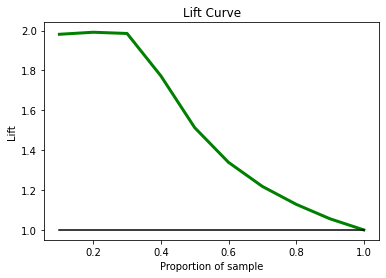



Fold 4:
Train: 2020-04-30 00:00:00 - 2020-07-31 00:00:00
Test: 2020-08-31 00:00:00 

Train shapes: X - (601574, 30), y - (601574,)
Test shapes: X - (150554, 30), y - (150554,)
Learning rate set to 0.5
0:	learn: 0.6018234	total: 214ms	remaining: 1.93s
1:	learn: 0.5505849	total: 377ms	remaining: 1.51s
2:	learn: 0.5210866	total: 545ms	remaining: 1.27s
3:	learn: 0.5039837	total: 704ms	remaining: 1.06s
4:	learn: 0.4911040	total: 881ms	remaining: 881ms
5:	learn: 0.4833513	total: 1.04s	remaining: 692ms
6:	learn: 0.4762711	total: 1.22s	remaining: 523ms
7:	learn: 0.4667935	total: 1.37s	remaining: 343ms
8:	learn: 0.4628343	total: 1.57s	remaining: 175ms
9:	learn: 0.4595804	total: 1.77s	remaining: 0us
Max probas: 0.9663046597886773
Lift: 0.8225549114503005 / 0.39068374138182976 = 2.105423963999533
Precision at 37606: 0.8225549114503005
Recall at 37606: 1.0


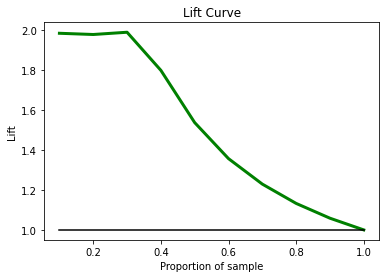



2020-09-30 00:00:00
2020-08-31T00:00:00.000000000


In [27]:
"""Fit / evaluate estimator for each split

params from config: 
    - top_K

"""

# DF to store metrics for each fold
metrics_df = pd.DataFrame(columns=['test_period', 'lift', 'precision_at_k', 'recall_at_k'])
top_K = int(features.shape[0] * top_K_coef)
print(f'top_K is {top_K_coef*100}% of dataset_size: {top_K}')

k = 1
for start_train, end_train, test_period in custom_ts_split(months, train_period = 1):
    
    print(f'Fold {k}:')    
    print(f'Train: {start_train} - {end_train}')
    print(f'Test: {test_period} \n')

    # Get train / test data for the split
    X_train = (features[(features.month >= start_train) & (features.month <= end_train)]
               .drop(columns=['user_id', 'month', 'target'], axis=1))
    X_test = (features[(features.month == test_period)]
              .drop(columns=['user_id', 'month', 'target'], axis=1))
    y_train = features.loc[(features.month >= start_train) & (features.month <= end_train), 'target']
    y_test = features.loc[(features.month == test_period), 'target']

    print(f'Train shapes: X is {X_train.shape}, y is {y_train.shape}')
    print(f'Test shapes: X is {X_test.shape}, y is {y_test.shape}')
    
    # Fit estimator
    clf.fit(X_train, y_train)
#     clf.fit(
#         X_train, y_train,
#         eval_set=(X_test, y_test),
#         cat_features=categories,
#         plot=True,
#         verbose=False
#     );
    
    y_pred = clf.predict(X_test)
    probas = clf.predict_proba(X_test)
    print(f'Max probas: {probas[:, 1].max()}')
    
    lift = lift_score(y_test, y_pred, probas[:, 1], top_K)
    precision_at_k = precision_at_k_score(y_test, y_pred, probas[:, 1], top_K)
    recall_at_k = recall_at_k_score(y_test, y_pred, probas[:, 1], top_K)
    
    metrics_df = metrics_df.append(
        dict(zip(metrics_df.columns, [test_period, lift, precision_at_k, recall_at_k])),
        ignore_index=True
    )

    k += 1
    
    print(f'Precision at {top_K}: {precision_at_k}')
    print(f'Recall at {top_K}: {recall_at_k}')
    plot_Lift_curve(y_test[:top_K], y_pred[:top_K], step=0.1)
    print('\n')

In [31]:
metrics_df

,test_period,lift,precision_at_k,recall_at_k
0,2020-05-31,2.107587,0.822768,1.0
1,2020-06-30,2.129249,0.829416,1.0
2,2020-07-31,2.105165,0.819337,1.0
3,2020-08-31,2.105424,0.822555,1.0


In [32]:
metrics_aggs = metrics_df[['lift', 'precision_at_k', 'recall_at_k']].agg(['max', 'min', 'std', 'mean'])
metrics = {
    f'{metric}_{agg}': metrics_aggs.loc[agg, metric]
    for metric in metrics_aggs.columns
    for agg in metrics_aggs.index
}

with open(train_metrics, 'w') as metrics_f:
    json.dump(obj=metrics, fp=metrics_f, indent=4)

metrics_aggs

,lift,precision_at_k,recall_at_k
max,2.129249,0.829416,1.0
min,2.105165,0.819337,1.0
std,0.011646,0.004233,0.0
mean,2.111856,0.823519,1.0


### Save model

In [30]:
joblib.dump(clf, model_path)

['../models/model.joblib']

# Predict

In [34]:
PATH_TO_DATA = '../data/raw'

In [35]:
df_scoring = pd.read_feather(os.path.join(PATH_TO_DATA, 'scoring_user_features.feather'))
df_scoring_targets = pd.read_feather(os.path.join(PATH_TO_DATA, 'scoring_target.feather'))
df_scoring_targets.head()

,user_id,month,target
0,0,2020-09-30,1.0
1,1,2020-09-30,1.0
2,2,2020-09-30,1.0
3,3,2020-09-30,0.0
4,4,2020-09-30,1.0


In [36]:
# Get train / test data for the split
scoring_period = str(df_scoring_targets.month.unique()[0])
print(f'Scoring period: {scoring_period}')
    
y_true_scoring = df_scoring_targets['target']
y_pred_scoring = clf.predict(df_scoring.drop(columns=['user_id', 'month'], axis=1))
probas_scoring = clf.predict_proba(df_scoring.drop(columns=['user_id', 'month'], axis=1))
print(f'Max probas: {probas[:, 1].max()}')

metrics_scoring = pd.DataFrame(columns=['scoring_period', 'lift', 'precision_at_k', 'recall_at_k'])

lift = lift_score(y_true_scoring, y_pred_scoring, probas_scoring[:, 1], top_K)
precision_at_k = precision_at_k_score(y_true_scoring, y_pred_scoring, probas_scoring[:, 1], top_K)
recall_at_k = recall_at_k_score(y_true_scoring, y_pred_scoring, probas_scoring[:, 1], top_K)

metrics_scoring = metrics_scoring.append(
    dict(zip(metrics_scoring.columns, [scoring_period, lift, precision_at_k, recall_at_k])),
    ignore_index=True,
)
metrics_scoring

Scoring period: 2020-09-30T00:00:00.000000000
Max probas: 0.9663046597886773
Lift: 0.5410040950912088 / 0.5003375450440177 = 1.0812782299669585


,scoring_period,lift,precision_at_k,recall_at_k
0,2020-09-30T00:00:00.000000000,1.081278,0.541004,1.0


In [37]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true_scoring, y_pred_scoring)



0.5069956656409516